In [1]:
import pandas as pd

# Leemos los dos archivos CSV que ya generaste
stats_df = pd.read_csv('/home/diego/Escritorio/Schaefer_1000/subjects_roi_timepoints_stats.csv')
subjects_db_df = pd.read_csv('/home/diego/Escritorio/Schaefer_1000/DataBaseSubjects.csv')

# Aseguramos que los IDs sean str y estén bien formateados
stats_df['SubjectID'] = stats_df['SubjectID'].astype(str).str.strip()
subjects_db_df['SubjectID'] = subjects_db_df['SubjectID'].astype(str).str.strip()

# Hacemos el merge (solo sujetos presentes en ambos)
merged = pd.merge(stats_df, subjects_db_df, on='SubjectID', how='inner')

# Revisamos el shape para chequear que hay 352 filas
print('Shape de merged:', merged.shape)
print(merged.head())


Shape de merged: (352, 31)
    SubjectID  N_timepoints   Signal_mean     Signal_std  ROI_means_mean  \
0  002_S_0295           140  1.280085e+03     249.133354    1.280085e+03   
1  002_S_0413           140  2.063082e+06  311111.594999    2.063082e+06   
2  002_S_0685           140  2.289281e+06  394640.566835    2.289281e+06   
3  002_S_0729           140  2.183635e+06  416440.780243    2.183635e+06   
4  002_S_1155           197  8.567840e+02     280.824501    8.567840e+02   

   ROI_stds_mean     Min_signal    Max_signal   Phase Sex  ...  MMSE  \
0       5.418058      76.231587  2.068851e+03  ADNI 2   M  ...  28.0   
1    9082.234705  199401.388846  3.247094e+06  ADNI 2   F  ...  29.0   
2    8798.925537  247037.805760  3.538542e+06  ADNI 2   F  ...  30.0   
3   10352.389564  118097.450641  3.439278e+06  ADNI 2   F  ...   NaN   
4       3.923276      86.693205  1.618082e+03  ADNI 3   M  ...  28.0   

  DIGITSCOR MOCA Ventricles  Hippocampus WholeBrain  MidTemp   ABETA    TAU  \
0   

Procesando 352 sujetos...
  Procesados 50/352 sujetos...
  Procesados 100/352 sujetos...
  Procesados 150/352 sujetos...
  Procesados 200/352 sujetos...
  Procesados 250/352 sujetos...
  Procesados 300/352 sujetos...
  Procesados 350/352 sujetos...

Procesamiento completado. Se obtuvieron matrices de conectividad para 352 sujetos.

Información de los primeros sujetos procesados:
    SubjectID  N_timepoints  N_ROIs  Mean_signal_original  \
0  002_S_0295           140    1000          1.280085e+03   
1  002_S_0413           140    1000          2.063082e+06   
2  002_S_0685           140    1000          2.289281e+06   
3  002_S_0729           140    1000          2.183635e+06   
4  002_S_1155           197    1000          8.567840e+02   

   Std_signal_original  Mean_signal_normalized  Std_signal_normalized  \
0           249.133354            1.650743e-16                    1.0   
1        311111.594999           -1.977783e-17                    1.0   
2        394640.566835          

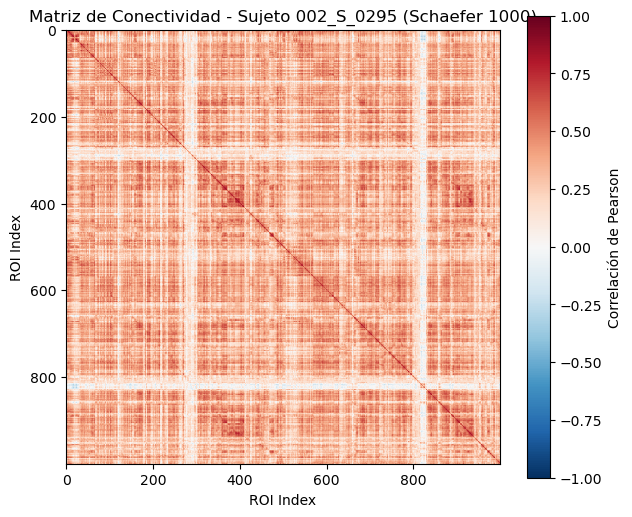

In [2]:
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy import stats # Para zscore
from nilearn.connectome import ConnectivityMeasure
from pathlib import Path
import matplotlib.pyplot as plt

# ==== CONFIGURACIÓN ====
subject_csv = '/home/diego/Escritorio/Schaefer_1000/DataBaseSubjects.csv'
roi_signals_dir = '/home/diego/Escritorio/Schaefer_1000/ROISignals'
roi_filename_template = 'ROISignals_{subject_id}.mat'
# output_csv = 'subjects_roi_timepoints_stats.csv' # Ya lo generamos

# ==== LEER LISTA DE SUJETOS Y METADATA ====
subjects_db_df = pd.read_csv(subject_csv)
subjects_db_df['SubjectID'] = subjects_db_df['SubjectID'].astype(str).str.strip()
# Usaremos el dataframe 'merged' que ya creamos y contiene la info de ResearchGroup
# Asegúrate de tener 'merged' de los pasos anteriores. Si no, recréalo:
# stats_df = pd.read_csv('subjects_roi_timepoints_stats.csv') # el que generamos antes
# stats_df['SubjectID'] = stats_df['SubjectID'].astype(str).str.strip()
# merged = pd.merge(stats_df, subjects_db_df, on='SubjectID', how='inner')
# O si prefieres, filtramos subject_ids basado en los que están en 'merged'
# Asumiré que 'merged' está disponible y contiene la columna 'ResearchGroup' y 'SubjectID'

subject_ids = merged['SubjectID'].tolist() # Usamos los IDs de 'merged' para consistencia

# Lista para almacenar las matrices de conectividad y otros datos
connectivity_matrices = {}
processed_subjects_info = []

# Inicializar la medida de conectividad
correlation_measure = ConnectivityMeasure(kind='correlation')

print(f"Procesando {len(subject_ids)} sujetos...")

for sid in subject_ids:
    mat_path = Path(roi_signals_dir) / roi_filename_template.format(subject_id=sid)
    if not mat_path.exists():
        print(f'[WARN] No encontrado: {mat_path} para sujeto {sid}')
        continue
    try:
        data = sio.loadmat(mat_path)
        keys = ["ROISignals", "signals", "roi_signals", "ROIsignals"]
        loaded_sigs = None
        for key in keys:
            if key in data:
                loaded_sigs = data[key]
                break
        
        if loaded_sigs is None:
            print(f'[WARN] No señales en: {mat_path} para sujeto {sid}')
            continue
            
        sigs = np.asarray(loaded_sigs)
        
        if sigs.ndim != 2 or sigs.shape[1] != 1000:
            print(f'[WARN] {mat_path} para sujeto {sid} tiene shape inesperado: {sigs.shape} (esperado [T, 1000])')
            continue
        
        if sigs.shape[0] < 5: # Muy pocas series temporales para analizar
             print(f'[WARN] {mat_path} para sujeto {sid} tiene muy pocos timepoints: {sigs.shape[0]}')
             continue

        # 1. Estandarización (Z-score) por ROI
        #    Esto normaliza cada columna (ROI) para tener media 0 y std 1
        sigs_normalized = stats.zscore(sigs, axis=0)
        
        # Verificar si hay NaNs después de zscore (puede pasar si una ROI tiene std=0, o sea, es constante)
        if np.isnan(sigs_normalized).any():
            print(f'[WARN] Sujeto {sid} tiene NaNs después de z-score. Verificando ROIs problemáticas.')
            # Opción: reemplazar NaNs con 0 o excluir la ROI o el sujeto.
            # Por ahora, reemplazamos con 0 para esas ROIs específicas.
            # Esto significa que esas ROIs no tendrán varianza y su correlación será 0 o NaN.
            # ConnectivityMeasure debería manejar ROIs con varianza cero (dando correlaciones NaN o 0).
            nan_cols = np.where(np.isnan(sigs_normalized).all(axis=0))[0]
            if len(nan_cols) > 0:
                 print(f"    ROIs con todos NaNs (varianza cero originalmente): {nan_cols}")
            sigs_normalized = np.nan_to_num(sigs_normalized) # Reemplaza NaN con 0, Inf con números grandes

        # 2. Calcular la matriz de conectividad
        #    ConnectivityMeasure espera una lista de matrices de series temporales.
        #    Aquí procesamos un sujeto a la vez.
        #    El resultado es (1, n_rois, n_rois), por eso tomamos [0]
        correlation_matrix = correlation_measure.fit_transform([sigs_normalized])[0]
        
        connectivity_matrices[sid] = correlation_matrix
        
        # Guardar información del sujeto procesado (opcional, para verificación)
        processed_subjects_info.append({
            'SubjectID': sid,
            'N_timepoints': sigs.shape[0],
            'N_ROIs': sigs.shape[1],
            'Mean_signal_original': np.mean(sigs),
            'Std_signal_original': np.std(sigs),
            'Mean_signal_normalized': np.mean(sigs_normalized), # Debería ser cercano a 0
            'Std_signal_normalized': np.std(sigs_normalized),   # Debería ser cercano a 1 (si no hay ROIs con std=0)
            'Conn_matrix_shape': correlation_matrix.shape
        })
        
        if len(processed_subjects_info) % 50 == 0: # Imprimir progreso
            print(f"  Procesados {len(processed_subjects_info)}/{len(subject_ids)} sujetos...")

    except Exception as e:
        print(f'[ERROR] Procesando {mat_path} para sujeto {sid} - {str(e)}')
        continue

print(f"\nProcesamiento completado. Se obtuvieron matrices de conectividad para {len(connectivity_matrices)} sujetos.")

# Convertir la info de sujetos procesados a DataFrame para revisión
df_processed_info = pd.DataFrame(processed_subjects_info)
print("\nInformación de los primeros sujetos procesados:")
print(df_processed_info.head())

print("\nEstadísticas de la información de los sujetos procesados:")
print(df_processed_info.describe())

# Ejemplo: Mostrar la matriz de conectividad de un sujeto (el primero que se procesó)
if processed_subjects_info:
    first_sid_processed = df_processed_info['SubjectID'].iloc[0]
    plt.figure(figsize=(7, 6))
    plt.imshow(connectivity_matrices[first_sid_processed], cmap='RdBu_r', vmin=-1, vmax=1)
    plt.colorbar(label='Correlación de Pearson')
    plt.title(f'Matriz de Conectividad - Sujeto {first_sid_processed} (Schaefer 1000)')
    plt.xlabel('ROI Index')
    plt.ylabel('ROI Index')
    plt.show()

    # También podrías querer guardar estas matrices, por ejemplo:
    # np.savez_compressed('connectivity_matrices_schaefer1000.npz', **connectivity_matrices)
    # O individualmente:
    # for sid, matrix in connectivity_matrices.items():
    #     np.save(f'conn_matrix_{sid}.npy', matrix)
else:
    print("No se procesó ningún sujeto exitosamente.")

<Figure size 1200x600 with 0 Axes>

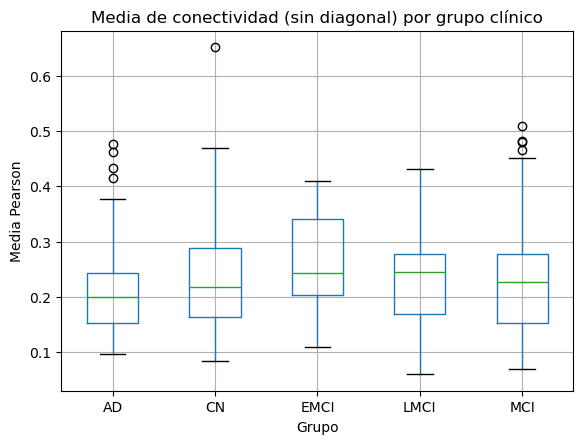

       count      mean       std       min       25%       50%       75%  \
Group                                                                      
AD      95.0  0.212254  0.080362  0.095913  0.152335  0.200005  0.243535   
CN      89.0  0.234593  0.098810  0.084632  0.163325  0.218261  0.289311   
EMCI    18.0  0.259316  0.093615  0.110175  0.203600  0.243856  0.341325   
LMCI    55.0  0.227473  0.075838  0.059977  0.169707  0.244395  0.277108   
MCI     95.0  0.228652  0.098978  0.070121  0.153062  0.226796  0.277007   

            max  
Group            
AD     0.475726  
CN     0.651807  
EMCI   0.410335  
LMCI   0.430521  
MCI    0.509377  


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Extraer las medias de conectividad (excluyendo la diagonal)
conn_means = []
groups = []
for sid in merged['SubjectID']:
    matrix = connectivity_matrices[sid]
    # Excluimos la diagonal (autocorrelación = 1)
    upper_tri = matrix[np.triu_indices(matrix.shape[0], k=1)]
    conn_means.append(np.mean(upper_tri))
    groups.append(merged.loc[merged['SubjectID'] == sid, 'ResearchGroup'].values[0])

# 2. Boxplot de la media de conectividad por grupo
import pandas as pd
df_conn = pd.DataFrame({'SubjectID': merged['SubjectID'], 'Group': groups, 'ConnMean': conn_means})

plt.figure(figsize=(12,6))
df_conn.boxplot(column='ConnMean', by='Group')
plt.title('Media de conectividad (sin diagonal) por grupo clínico')
plt.suptitle('')
plt.ylabel('Media Pearson')
plt.xlabel('Grupo')
plt.show()

print(df_conn.groupby('Group')['ConnMean'].describe())


In [4]:
from scipy.stats import kruskal

# Test Kruskal-Wallis entre los grupos principales
groups_labels = df_conn['Group'].unique()
group_data = [df_conn.loc[df_conn['Group']==g, 'ConnMean'].values for g in groups_labels]

stat, p = kruskal(*group_data)
print(f"Test Kruskal-Wallis entre grupos (ConnMean): estadístico={stat:.3f}, p-valor={p:.3e}")


Test Kruskal-Wallis entre grupos (ConnMean): estadístico=6.070, p-valor=1.940e-01


In [5]:
# Asumimos que df_conn tiene columnas 'SubjectID', 'Group', 'ConnMean'
# (adaptá 'Group' por 'ResearchGroup' si tu DataFrame usa ese nombre)

outliers_info = []

for group, subdf in df_conn.groupby('Group'):
    q1 = subdf['ConnMean'].quantile(0.25)
    q3 = subdf['ConnMean'].quantile(0.75)
    iqr = q3 - q1
    low_thr = q1 - 1.5 * iqr
    high_thr = q3 + 1.5 * iqr
    # Outliers por debajo y por arriba
    is_outlier = (subdf['ConnMean'] < low_thr) | (subdf['ConnMean'] > high_thr)
    outliers = subdf[is_outlier]
    outliers_info.append({
        "Group": group,
        "N_outliers": is_outlier.sum(),
        "Total": len(subdf),
        "Prop_outliers": is_outlier.sum() / len(subdf),
        "First_outliers": outliers[['SubjectID', 'ConnMean']].head().to_dict(orient='records')
    })
    print(f"Grupo {group}: {is_outlier.sum()} outliers de {len(subdf)} sujetos (proporción={is_outlier.sum() / len(subdf):.2f})")
    print("  Ejemplo:", outliers[['SubjectID', 'ConnMean']].head().to_string(index=False))

# Guardar lista para usarla después si lo necesitás


Grupo AD: 4 outliers de 95 sujetos (proporción=0.04)
  Ejemplo:  SubjectID  ConnMean
019_S_5012  0.461876
098_S_6658  0.432823
100_S_6713  0.475726
135_S_6284  0.415463
Grupo CN: 1 outliers de 89 sujetos (proporción=0.01)
  Ejemplo:  SubjectID  ConnMean
100_S_6308  0.651807
Grupo EMCI: 0 outliers de 18 sujetos (proporción=0.00)
  Ejemplo: Empty DataFrame
Columns: [SubjectID, ConnMean]
Index: []
Grupo LMCI: 0 outliers de 55 sujetos (proporción=0.00)
  Ejemplo: Empty DataFrame
Columns: [SubjectID, ConnMean]
Index: []
Grupo MCI: 4 outliers de 95 sujetos (proporción=0.04)
  Ejemplo:  SubjectID  ConnMean
006_S_6243  0.480299
006_S_6441  0.509377
006_S_6674  0.465985
305_S_6498  0.481269


In [6]:
# Si todavía no lo tenés, asegurate de tener un DataFrame con 'SubjectID', 'ResearchGroup' y 'ConnMean'
df_conn = merged[['SubjectID', 'ResearchGroup', 'ConnMean']].copy()

outliers_summary = []
outliers_by_group = {}

for group, subdf in df_conn.groupby('ResearchGroup'):
    q1 = subdf['ConnMean'].quantile(0.25)
    q3 = subdf['ConnMean'].quantile(0.75)
    iqr = q3 - q1
    low_thr = q1 - 1.5 * iqr
    high_thr = q3 + 1.5 * iqr
    # Detectar outliers
    is_outlier = (subdf['ConnMean'] < low_thr) | (subdf['ConnMean'] > high_thr)
    outliers = subdf[is_outlier]
    # Guardar resultados
    outliers_by_group[group] = outliers
    outliers_summary.append({
        "Group": group,
        "N_outliers": is_outlier.sum(),
        "Total": len(subdf),
        "Prop_outliers": is_outlier.sum() / len(subdf) if len(subdf) else np.nan,
        "First_outliers": outliers[['SubjectID', 'ConnMean']].head().to_dict(orient='records')
    })
    print(f"Grupo {group}: {is_outlier.sum()} outliers de {len(subdf)} sujetos (proporción={is_outlier.sum() / len(subdf):.2f})")
    print(outliers[['SubjectID', 'ConnMean']].head().to_string(index=False))

# Convertir resumen a DataFrame para ver rápidamente
df_outlier_summary = pd.DataFrame(outliers_summary)
print("\nResumen outliers por grupo:")
print(df_outlier_summary)


KeyError: "['ConnMean'] not in index"